In [ ]:
!pip install -U transformers datasets huggingface_hub tensorboard==2.11

In [5]:
from datasets import load_dataset, Dataset

In [10]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, DebertaV2Model, DebertaV2Tokenizer, AdamW
from transformers import  AutoConfig, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn


In [7]:
ts = load_dataset('csv', data_files='/content/combined_toxic.csv', encoding='latin-1')

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
ts['train']

Dataset({
    features: ['comment_text', 'label'],
    num_rows: 35117
})

In [9]:
config = {
    'model_name': 'microsoft/deberta-v3-small',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.2,
    'hidden_dropout_rate': 0.3,

}

In [7]:
from txdataprocessing import *
from debertaclassifier import *

In [41]:
from evalmetrics import plot_metrics

def evaluate_model(model, data_loader, device, class_weights=None, criterion=None):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_indices = []

    with torch.no_grad(): # disables gradient calculations as only evaluation is being done and NOT training.
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['idx']

            logits, _ = model(input_ids, attention_mask)
            #outputs = model(input_ids, attention_mask)
            if criterion is not None:
                loss = criterion(logits, labels)
                #loss = criterion(outputs, labels)
                total_loss += loss.item()

            probs = torch.softmax(logits, dim=1) # logits converted to probablities using the softmax function
            #probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(logits, dim=1) #predicted class determined by selecting the class with the highest probablity
            #preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_indices.extend(indices.numpy())

    metrics = {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'indices': all_indices,
        'recall': recall_score(all_labels, all_preds),
        'loss': total_loss / len(data_loader) if criterion is not None else None
    }

    return metrics

def train_model(config,model,train_loader, val_loader, test_loader, num_epochs=10,patiencestep=3,lrate=2e-5,weight_decay=0.01,factorrate=0.1,max_norm=1.0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = config['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=lrate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=factorrate, patience=patiencestep, verbose=True
    )  # learning rate scheduler that reduces the learning rate when the validation metric (recall) plateaus. This helps to fine-tune the model and prevent overfitting.

    # early stopping and metrics initialization
    best_val_recall = 0
    patience = patiencestep
    patience_counter = 0

    early_stopping = EarlyStopping(patience=patiencestep)

    train_losses = []
    val_losses = []
    val_recalls = []
    all_labels = []
    all_probs = []

    for epoch in range(config['epochs']):
        print(f'\nEpoch {epoch + 1}/{config["epochs"]}')

        # Training Mode
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_mask, labels-labels)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()
            #scheduler.step()

            total_train_loss += loss.item()
            #progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Mode
        val_metrics = evaluate_model(
            model,
            val_loader,
            device,
            class_weights,
            criterion
        )
        val_losses.append(val_metrics['loss'])
        val_recalls.append(val_metrics['recall'])

        # Assign val_preds from the validation metrics returned in val_metrics
        val_preds = val_metrics['predictions']
        val_labels = val_metrics['labels'] # Get validation labels from val_metrics

        all_labels.extend(val_metrics['labels'])  # Extend with validation labels
        all_probs.extend(val_metrics['probabilities'])
        #all_probs.extend(val_preds)  # Extend with validation predictions (probs)

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_metrics["loss"]:.4f}')
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds))

        cs_consolidated_report =[]
        cs_report_per_epoch = classification_report(val_labels, val_preds, output_dict=True)
        #cs_report_df = pd.DataFrame(cs_report_per_epoch).transpose()
        cs_report_df = pd.DataFrame(cs_report_per_epoch).transpose()
        cs_report_df['epoch'] = epoch + 1
        cs_consolidated_report.append(cs_report_df)

        #print(f'Val Recall: {val_metrics["recall"]:.4f}')

        scheduler.step(val_metrics['recall'])

        if val_metrics['recall'] > best_val_recall:
            best_val_recall = val_metrics['recall']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
        cs_df = pd.concat(cs_consolidated_report, ignore_index=True)
        print(cs_df)


    # Final evaluation on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        class_weights,
        criterion
    )

    print('\nTest Set Results:')
    print(f'Test Loss: {test_metrics["loss"]:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_metrics['labels'], test_metrics['predictions']))

    # Plot confusion matrix
    plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, test_metrics)

    #return model
    return train_losses, val_losses, val_recalls, model

In [43]:
ds = ts

In [44]:
ds['train'].features

{'comment_text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [45]:
#Calculate class weights

ds_df = ds['train'].to_pandas()
class_weights = calculate_class_weights(ds_df['label'].values)
config['class_weights'] = class_weights
print("\nClass Weights:")
print(class_weights)

# Calculate class distribution
class_distribution = ds_df['label'].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print("\nClass Distribution (%):")
print(class_distribution / len(ds_df) * 100)


Class Weights:
tensor([0.8179, 1.2863])

Class Distribution:
label
0    21467
1    13650
Name: count, dtype: int64

Class Distribution (%):
label
0    61.129937
1    38.870063
Name: count, dtype: float64


In [2]:
def clear_memory():
    import gc, torch
    gc.collect()
    torch.cuda.empty_cache()
clear_memory()

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
# Initialize CustomDeberta
model = CustomDebertaClassifier().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training set size: 21069
Validation set size: 7024
Test set size: 7024

Epoch 1/10


Epoch 1/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 1:
Training Loss: 0.2751
Validation Loss: 0.2581

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4294
           1       0.87      0.96      0.92      2730

    accuracy                           0.93      7024
   macro avg       0.92      0.94      0.93      7024
weighted avg       0.94      0.93      0.93      7024

   precision    recall  f1-score      support  epoch
0   0.975087  0.911504  0.942224  4294.000000      1
1   0.873754  0.963370  0.916376  2730.000000      1
2   0.931663  0.931663  0.931663     0.931663      1
3   0.924421  0.937437  0.929300  7024.000000      1
4   0.935702  0.931663  0.932178  7024.000000      1

Epoch 2/10


Epoch 2/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 2:
Training Loss: 0.1931
Validation Loss: 0.2301

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4294
           1       0.87      0.97      0.92      2730

    accuracy                           0.93      7024
   macro avg       0.92      0.94      0.93      7024
weighted avg       0.94      0.93      0.93      7024

   precision    recall  f1-score      support  epoch
0   0.976232  0.908710  0.941262  4294.000000      2
1   0.870499  0.965201  0.915407  2730.000000      2
2   0.930666  0.930666  0.930666     0.930666      2
3   0.923366  0.936956  0.928334  7024.000000      2
4   0.935137  0.930666  0.931213  7024.000000      2

Epoch 3/10


Epoch 3/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 3:
Training Loss: 0.1602
Validation Loss: 0.2732

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      4294
           1       0.87      0.97      0.92      2730

    accuracy                           0.93      7024
   macro avg       0.92      0.94      0.93      7024
weighted avg       0.94      0.93      0.93      7024

   precision    recall  f1-score      support  epoch
0   0.980328  0.905217  0.941276  4294.000000      3
1   0.866950  0.971429  0.916220  2730.000000      3
2   0.930951  0.930951  0.930951     0.930951      3
3   0.923639  0.938323  0.928748  7024.000000      3
4   0.936262  0.930951  0.931538  7024.000000      3

Epoch 4/10


Epoch 4/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 4:
Training Loss: 0.1324
Validation Loss: 0.3719

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      4294
           1       0.80      0.98      0.88      2730

    accuracy                           0.90      7024
   macro avg       0.90      0.91      0.90      7024
weighted avg       0.92      0.90      0.90      7024

   precision    recall  f1-score      support  epoch
0   0.988562  0.845366  0.911373  4294.000000      4
1   0.801909  0.984615  0.883920  2730.000000      4
2   0.899487  0.899487  0.899487     0.899487      4
3   0.895236  0.914991  0.897647  7024.000000      4
4   0.916016  0.899487  0.900703  7024.000000      4

Epoch 5/10


Epoch 5/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 5:
Training Loss: 0.1224
Validation Loss: 0.2753

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4294
           1       0.88      0.97      0.92      2730

    accuracy                           0.94      7024
   macro avg       0.93      0.94      0.94      7024
weighted avg       0.94      0.94      0.94      7024

   precision    recall  f1-score      support  epoch
0   0.978898  0.918258  0.947609  4294.000000      5
1   0.882844  0.968864  0.923856  2730.000000      5
2   0.937927  0.937927  0.937927     0.937927      5
3   0.930871  0.943561  0.935732  7024.000000      5
4   0.941565  0.937927  0.938377  7024.000000      5

Epoch 6/10


Epoch 6/10: 100%|██████████| 1317/1317 [10:15<00:00,  2.14it/s]


Epoch 6:
Training Loss: 0.1062
Validation Loss: 0.3210

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4294
           1       0.86      0.97      0.91      2730

    accuracy                           0.93      7024
   macro avg       0.92      0.94      0.93      7024
weighted avg       0.93      0.93      0.93      7024

   precision    recall  f1-score      support  epoch
0   0.979530  0.902655  0.939522  4294.000000      6
1   0.863710  0.970330  0.913921  2730.000000      6
2   0.928958  0.928958  0.928958     0.928958      6
3   0.921620  0.936492  0.926722  7024.000000      6
4   0.934515  0.928958  0.929572  7024.000000      6

Epoch 7/10


Epoch 7/10: 100%|██████████| 1317/1317 [10:16<00:00,  2.14it/s]


Epoch 7:
Training Loss: 0.0866
Validation Loss: 0.2826

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4294
           1       0.89      0.96      0.92      2730

    accuracy                           0.94      7024
   macro avg       0.93      0.94      0.94      7024
weighted avg       0.94      0.94      0.94      7024

Early stopping triggered!

Test Set Results:
Test Loss: 0.2599

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4294
           1       0.90      0.96      0.93      2730

    accuracy                           0.94      7024
   macro avg       0.94      0.95      0.94      7024
weighted avg       0.95      0.94      0.94      7024



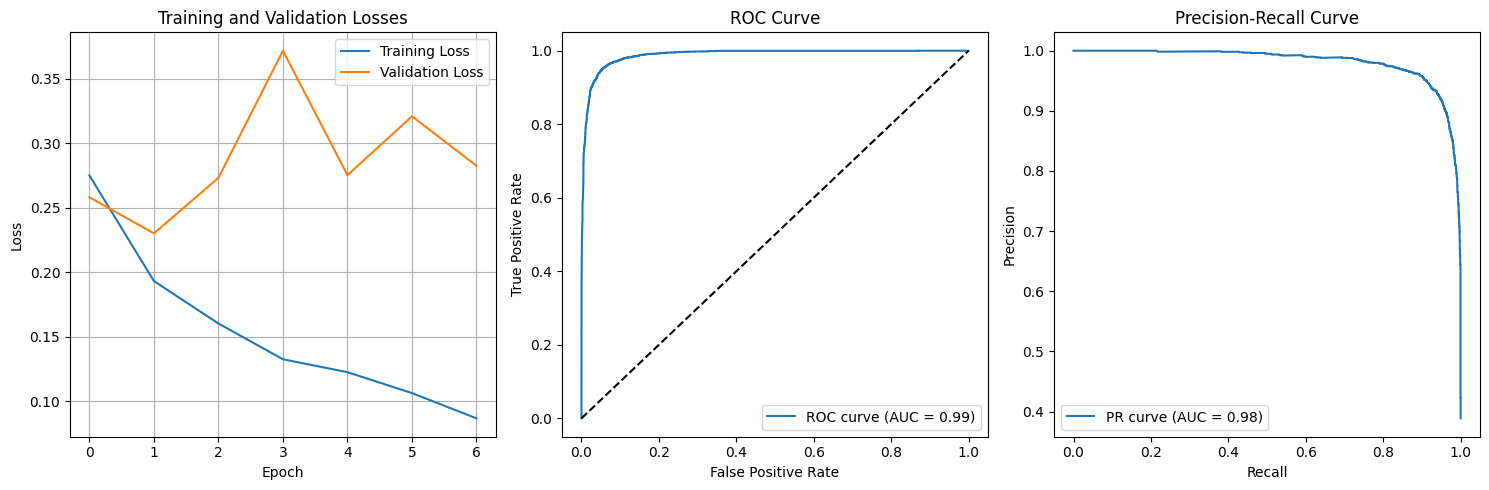

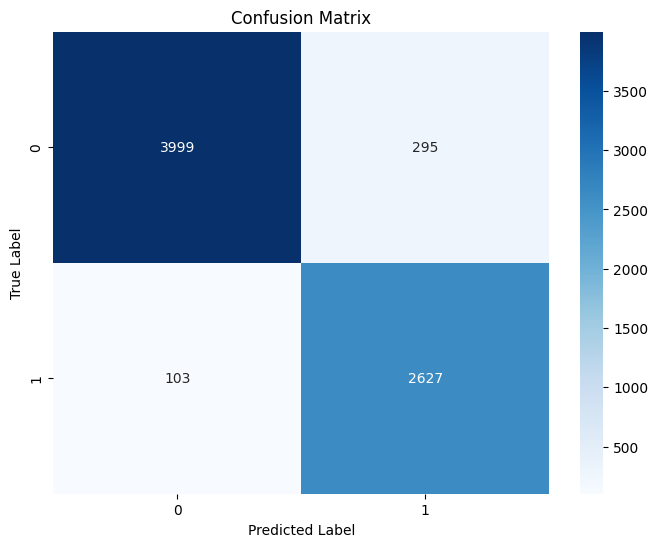

In [47]:

train_dataset, val_dataset, test_dataset = create_data_splits(
        texts=ds['train']['comment_text'],
        labels=ds['train']['label'],
        tokenizer=tokenizer,
        test_size=0.20,
        val_size=0.25
    )


print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16
)


# train model
train_losses, val_losses, val_recalls, _ = train_model(
     config, model, train_loader, val_loader, test_loader
  )

# Load best model and evaluate by loading model weights onto the correct device
state_dict = torch.load('best_model.pt', map_location=device, weights_only=True)

# Load  weights and other necessary state information into the model
model.load_state_dict(state_dict)

test_metrics = evaluate_model(model, test_loader, device)

In [49]:
# Save the model and tokenizer
OUTPUT_DIR = '/content/drive/MyDrive/debertatftmdl'

# Save the model weights using torch.save
torch.save(model.state_dict(), f"{OUTPUT_DIR}/pytorch_model.bin")

# Save the tokenizer
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"Model weights saved to {OUTPUT_DIR}/pytorch_model.bin")
print(f"Tokenizer saved to {OUTPUT_DIR}")

Model weights saved to /content/drive/MyDrive/debertatftmdl/pytorch_model.bin
Tokenizer saved to /content/drive/MyDrive/debertatftmdl


# Test Inference

In [4]:
OUTPUT_DIR='/content/drive/MyDrive/debertatftmdl'

In [8]:
import os, warnings
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

def infer_toxicvalidator(contextstr, mdlpath=OUTPUT_DIR):
    try:
        ft_model = CustomDebertaClassifier()
        binpath = mdlpath + '/pytorch_model.bin'
        if os.path.exists(binpath):
            ft_model.load_state_dict(torch.load(binpath))
            ft_model.eval()
            tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR +'/')
            result = {}
            result['contextstr'] = contextstr
            with torch.no_grad():
                #Tokenize inputs
                inputs = tokenizer(contextstr, return_tensors="pt")
                output = ft_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                # get the outputtensor
                evallabel = output[0].argmax().item()
                result['evallabel'] = evallabel
                if evallabel==1:
                  result['prediction'] = 'toxic'
                else:
                  result['prediction'] = 'non-toxic'
            return result

    except Exception as e:
        return (f"Encountered error while performing inference: {e}")

In [11]:
infer_toxicvalidator('I love you')

{'contextstr': 'I love you', 'evallabel': 0, 'prediction': 'non-toxic'}

In [12]:
infer_toxicvalidator('You are a wonderful person')

{'contextstr': 'You are a wonderful person',
 'evallabel': 0,
 'prediction': 'non-toxic'}

In [58]:
infer_toxicvalidator('You are  wonderful person')

{'contextstr': 'You are  wonderful person',
 'evallabel': 0,
 'prediction': 'non-toxic'}

In [13]:
testlist = ["This is a beautiful movie.",
        "This is such a hateful and horrible movie",
        "You are a wonderful person!",
        "I hate you and wish you would die",
        "The weather is nice today",
        ""
        "You're completely stupid and useless"]

In [14]:
resultdict = {'contextstr': [], 'evallabel': [], 'predictionresult': []}

for s in testlist:
    t = infer_toxicvalidator(contextstr=s)
    resultdict['contextstr'].append(s)
    resultdict['evallabel'].append(t['evallabel'])
    resultdict['predictionresult'].append(t['prediction'])
resultdf = pd.DataFrame(resultdict)

In [15]:
resultdf

,contextstr,evallabel,predictionresult
0,This is a beautiful movie.,0,non-toxic
1,This is such a hateful and horrible movie,1,toxic
2,You are a wonderful person!,0,non-toxic
3,I hate you and wish you would die,1,toxic
4,The weather is nice today,0,non-toxic
5,You're completely stupid and useless,1,toxic


In [17]:
test_cases = [
      "beautiful movie.",
      "This is a beautiful movie",
      "This is such a hateful and horrible movie",
      "You are an asshole",
      "wonderful person",
      "You are a wonderful person!",
      "I hate you and wish you would die",
      "The weather is nice today",
      "You're completely stupid and useless",
      "You idiot you will pay for this",
      "You are rotten bloody person",
      "You should be ashamed of yourself",
      "You should die or hang yourself why are your still living"
  ]
resultd = {'contextstr': [], 'evallabel': [], 'predictionresult': []}

for s in test_cases:
    t = infer_toxicvalidator(contextstr=s)
    resultd['contextstr'].append(s)
    resultd['evallabel'].append(t['evallabel'])
    resultd['predictionresult'].append(t['prediction'])
resultddf = pd.DataFrame(resultd)

In [18]:
resultddf

,contextstr,evallabel,predictionresult
0,beautiful movie.,0,non-toxic
1,This is a beautiful movie,0,non-toxic
2,This is such a hateful and horrible movie,1,toxic
3,You are an asshole,1,toxic
4,wonderful person,0,non-toxic
5,You are a wonderful person!,0,non-toxic
6,I hate you and wish you would die,1,toxic
7,The weather is nice today,0,non-toxic
8,You're completely stupid and useless,1,toxic
9,You idiot you will pay for this,1,toxic


# <font color='Gold'>**Test second approach**</font>